CSV date range:
  Min date: 2021-01-01 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1117
Rows that have all features = NaN: 21
TRAIN rows: 990
VAL   rows: 106
TEST  rows: 21

=== Training LSTM model ===
[LSTM] Loaded existing model from best_LSTM_US_10Yr_Bonds_V1.pt
LSTM has no real test data => skip MAPE

=== Training GRU model ===
[GRU] Loaded existing model from best_GRU_US_10Yr_Bonds_V1.pt
GRU has no real test data => skip MAPE

=== Training RNN model ===
[RNN] Loaded existing model from best_RNN_US_10Yr_Bonds_V1.pt
RNN has no real test data => skip MAPE

=== Training CNN model ===
[CNN] Loaded existing model from best_CNN_US_10Yr_Bonds_V1.pt
CNN has no real test data => skip MAPE

=== Training Transformer model ===
[Transformer] Loaded existing model from best_Transformer_US_10Yr_Bonds_V1.pt
Transformer has no real test data => skip MAPE

=== Training N-BEATS model ===
[N-BEATS] Loaded existing model from best_N-BEATS_US_10Yr_Bonds_V1.pt
N-BEATS has no real test 

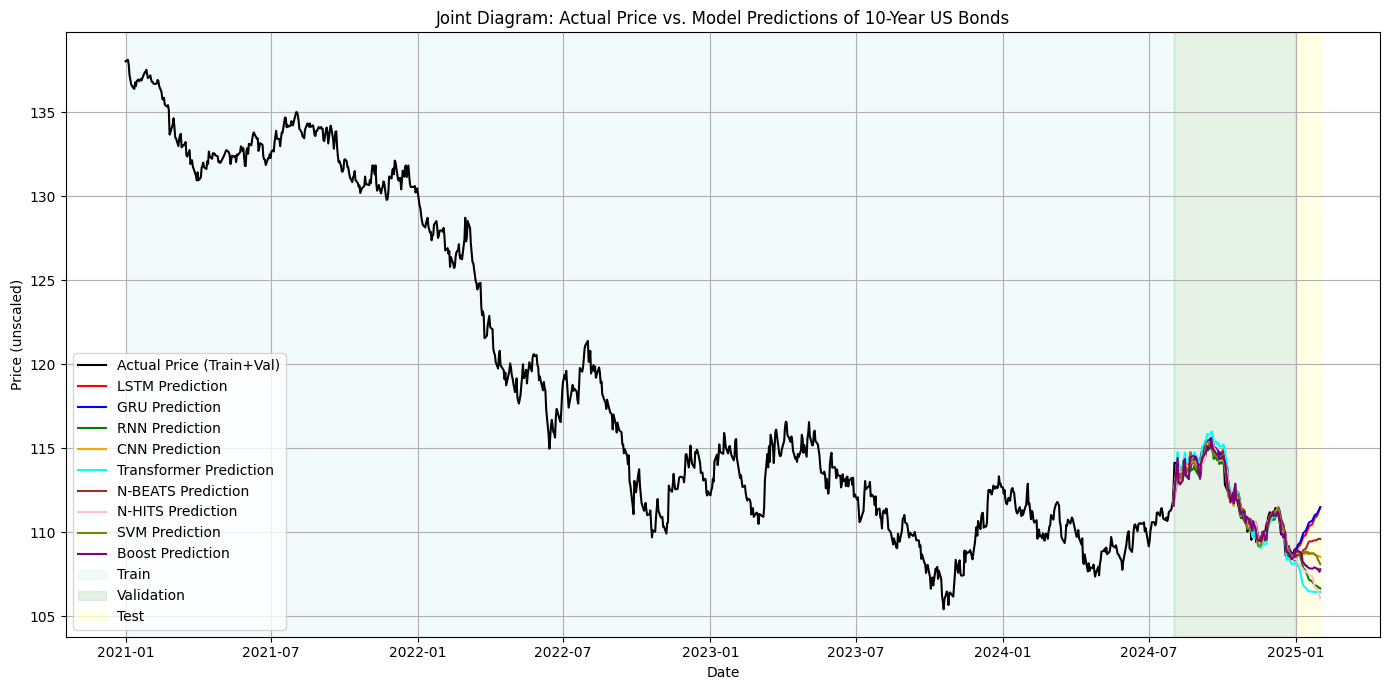

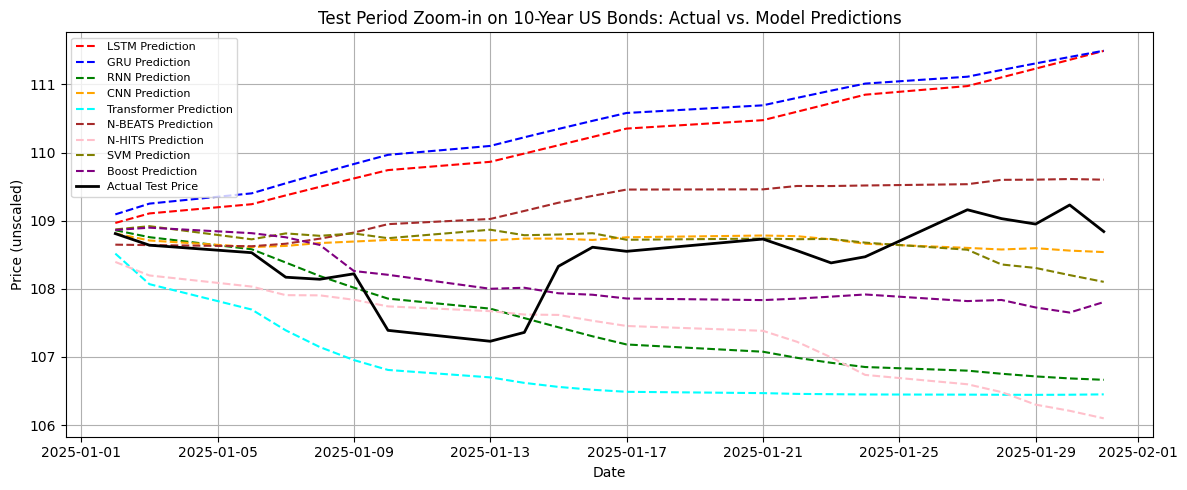

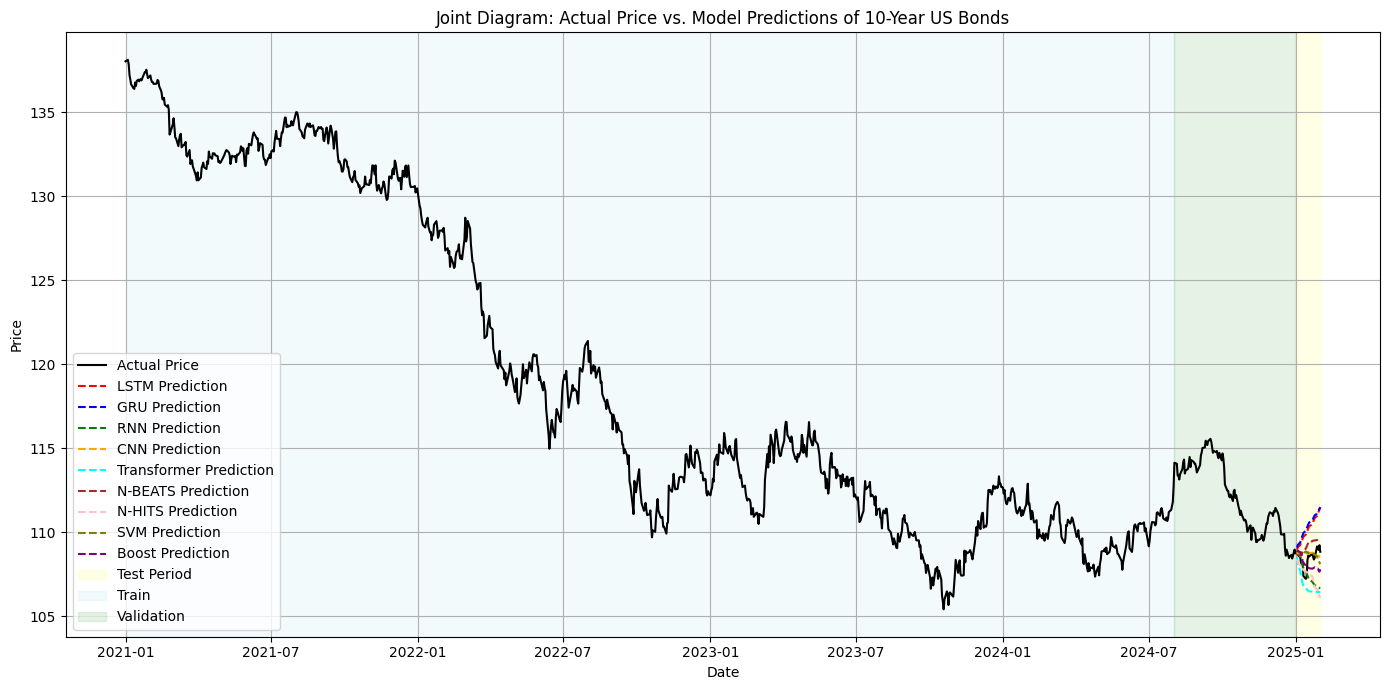

Model: LSTM - Cumulative Absolute Error: 37.5545
Model: GRU - Cumulative Absolute Error: 41.1040
Model: RNN - Cumulative Absolute Error: 23.3130
Model: CNN - Cumulative Absolute Error: 9.6605
Model: Transformer - Cumulative Absolute Error: 33.8066
Model: N-BEATS - Cumulative Absolute Error: 16.2713
Model: N-HITS - Cumulative Absolute Error: 25.5059
Model: SVM - Cumulative Absolute Error: 12.0716
Model: Boost - Cumulative Absolute Error: 14.7738


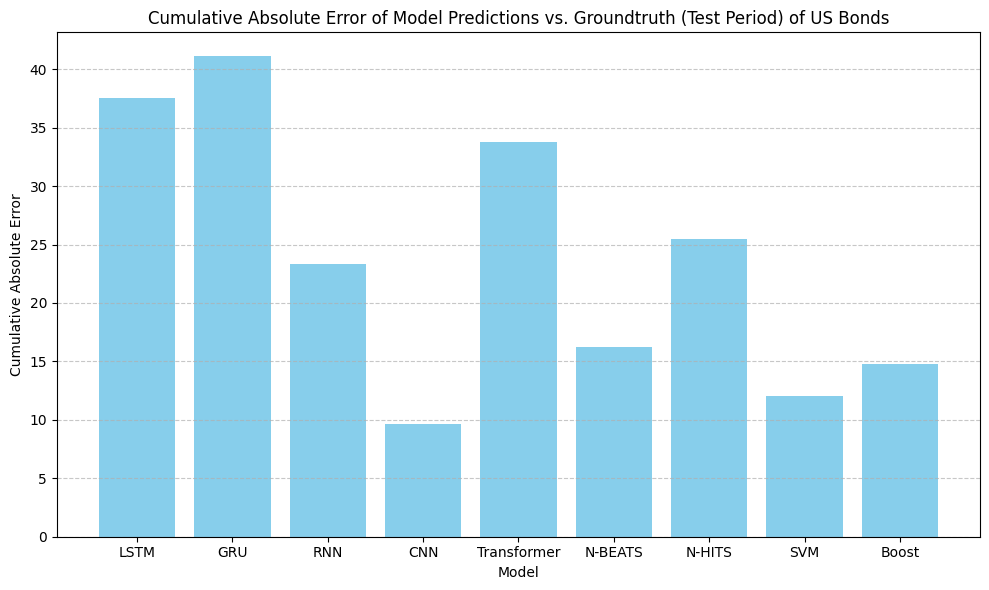

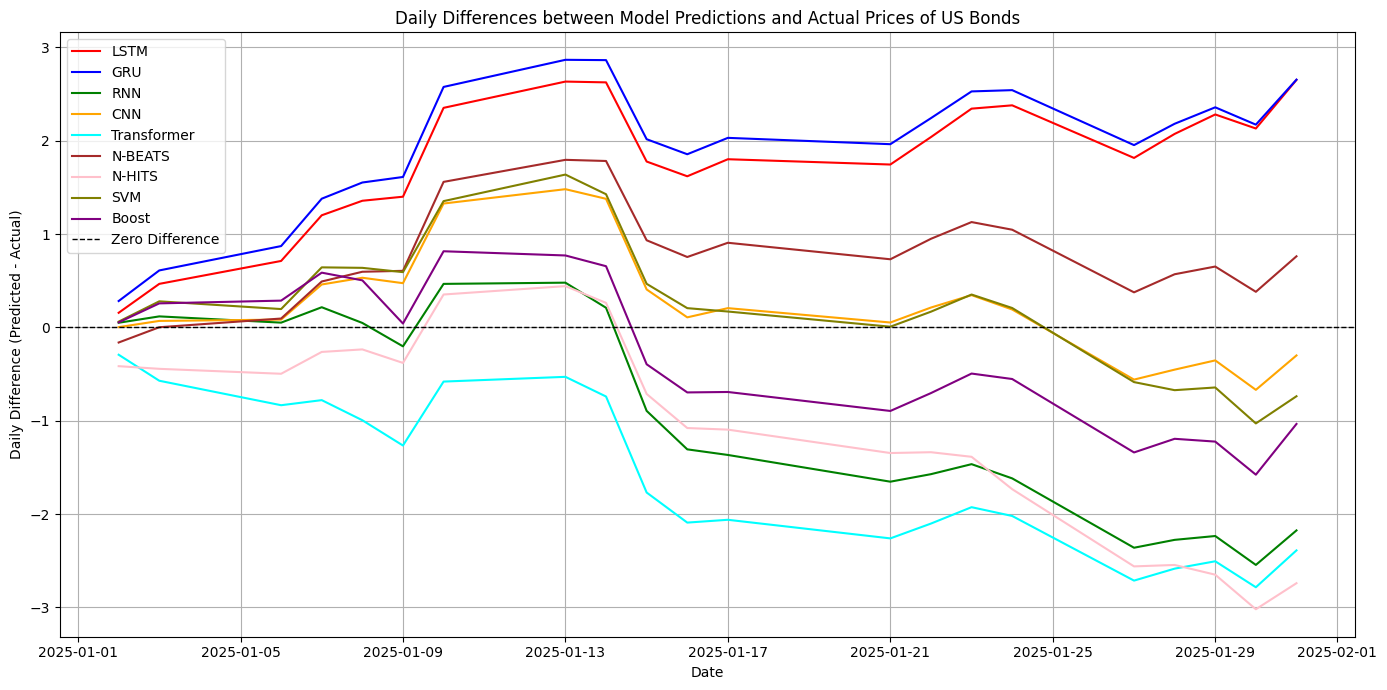

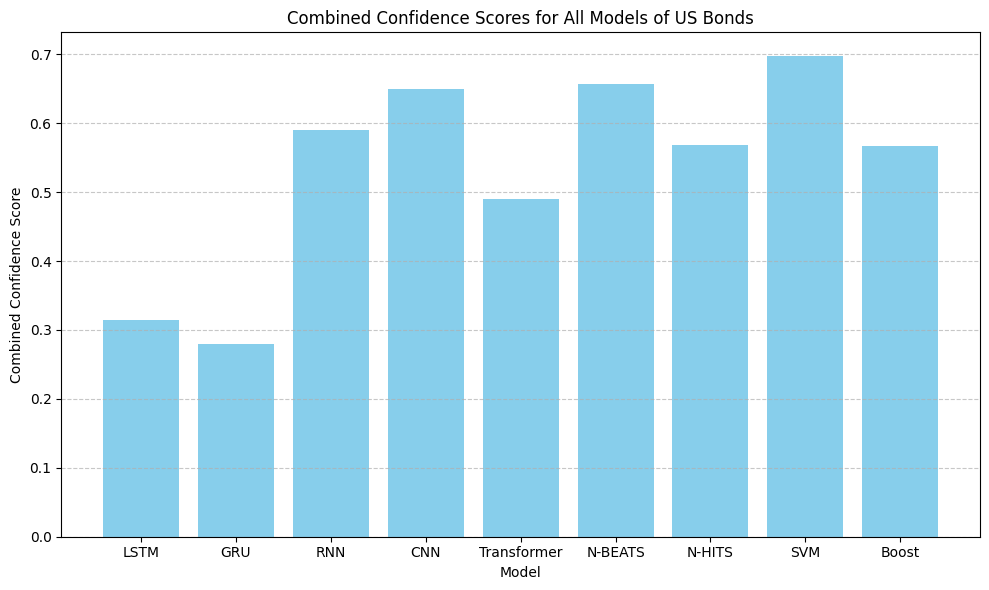

Normalized Confidence Scores for Top 5 Models (Sum = 1):
     Model  normalized_confidence
7      SVM               0.220395
5  N-BEATS               0.207725
3      CNN               0.205535
2      RNN               0.186481
6   N-HITS               0.179865

Selected models and their normalized confidence scores (ready for later polynomial fitting):
{'SVM': 0.22039500970609818, 'N-BEATS': 0.20772484531520252, 'CNN': 0.20553450741855786, 'RNN': 0.18648069635016196, 'N-HITS': 0.1798649412099795}
Polynomial-fitting test DataFrame columns: ['Date', 'Actual', 'SVM', 'N-BEATS', 'CNN', 'RNN', 'N-HITS']
Number of rows in polynomial-fitting test DataFrame: 21

=== Best Polynomial Orders (Test Window) ===
[Actual] -> Best Degree: 3, Val MSE = 0.104808
     Polynomial Expression: y = -4.2867e-04*x^3+2.5859e+01*x^2-5.1996e+05*x+3.4850e+09

[SVM] -> Best Degree: 6, Val MSE = 0.004067
     Polynomial Expression: y = -5.2270e-16*x^6+2.4441e-11*x^5-6.8886e-08*x^4-8.4457e-03*x^3-2.8702e+01*x^2+3.970

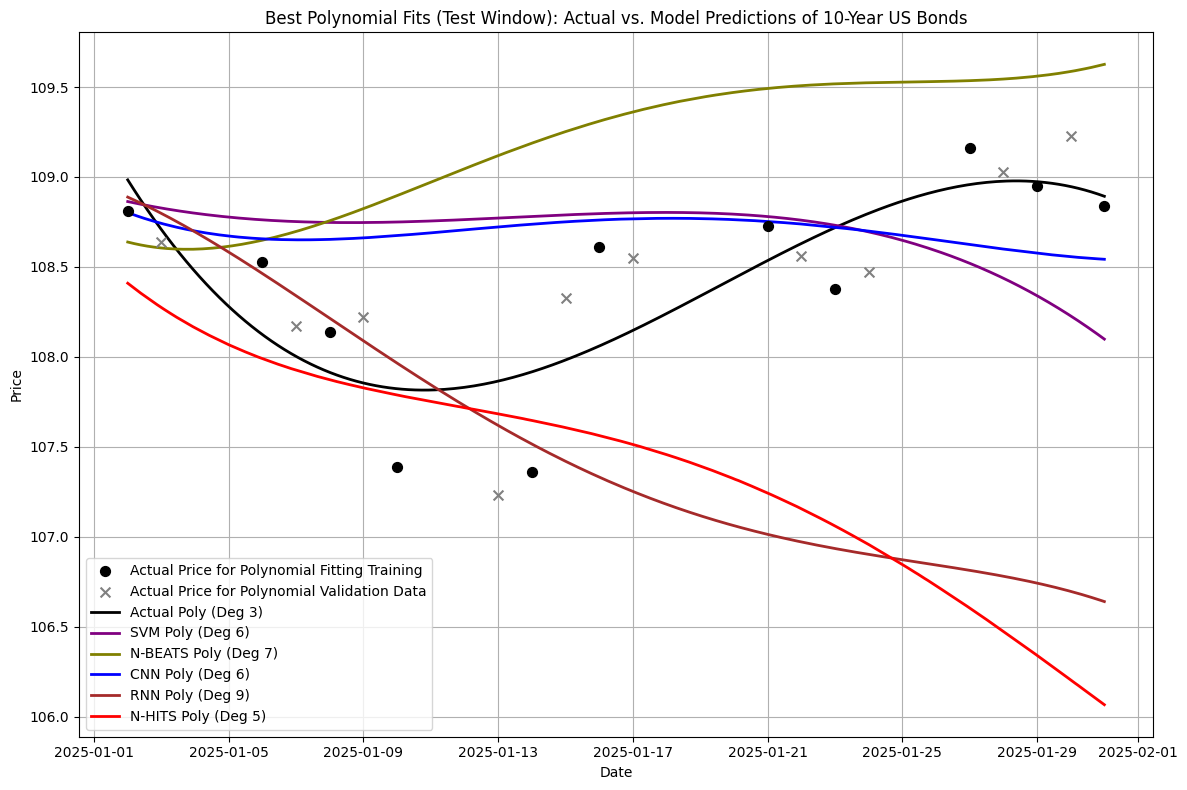

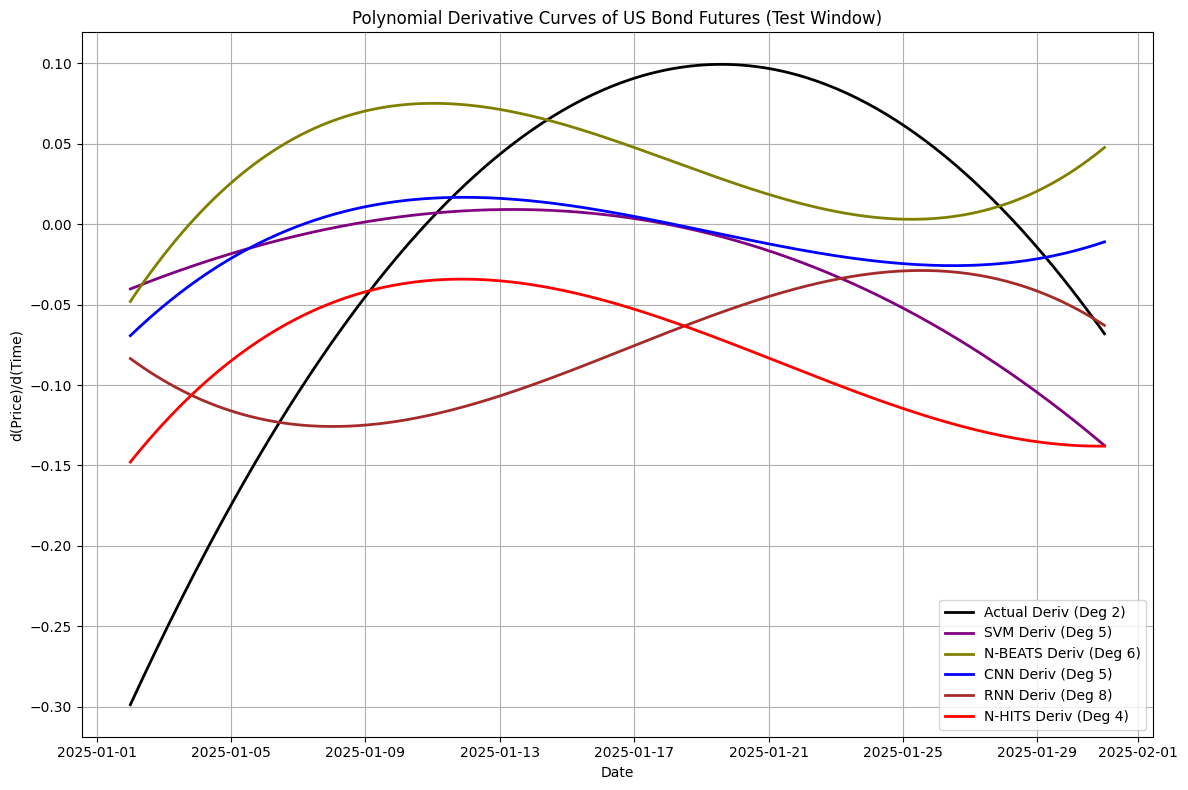


=== Derivative Polynomial Expressions ===
[Actual] (Degree 3) -> derivative: -1.2860e-03*x^2+5.1718e+01*x-5.1996e+05
[SVM] (Degree 6) -> derivative: -3.1362e-15*x^5+1.2220e-10*x^4-2.7554e-07*x^3-2.5337e-02*x^2-5.7403e+01*x+3.9706e+06
[N-BEATS] (Degree 7) -> derivative: 1.7088e-18*x^6-5.4679e-14*x^5-2.1148e-10*x^4+1.0184e-05*x^3+1.5425e-01*x^2-6.8628e+02*x-2.9994e+07
[CNN] (Degree 6) -> derivative: 2.7835e-14*x^5-1.0884e-09*x^4+2.5072e-06*x^3+2.2627e-01*x^2+5.0324e+02*x-3.5554e+07
[RNN] (Degree 9) -> derivative: -1.5548e-27*x^8+3.3964e-23*x^7+4.6167e-19*x^6-1.4133e-15*x^5-1.4097e-10*x^4-2.2695e-06*x^3-5.6985e-03*x^2+4.3285e+02*x+5.6378e+06
[N-HITS] (Degree 5) -> derivative: 9.4929e-10*x^4-4.5893e-05*x^3+4.6536e-01*x^2+6.0811e+03*x-9.2508e+07


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import joblib

# Additional imports for sklearn-based models:
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

###############################################################
# 1. Set random seeds
###############################################################
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################
# Global hyperparameters
###############################################################
WINDOW_SIZE = 30
NUM_EPOCHS  = 800

features = ["Price", "Open", "High", "Low"]
csv_file = "US 10 Year T-Note Futures Historical Data.csv"

###############################################################
# 2. Load & Clean CSV
###############################################################
df = pd.read_csv(csv_file)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

###############################################################
# 4. Fit MinMaxScaler on TRAIN only
###############################################################
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

# Combine all scaled data (for validation and test walk-forward procedures)
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################
# 5A. Create the training sequences
###############################################################
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# For sklearn-based models we flatten the time window.
X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))
# y_train_all remains shape: (n_samples, 4)

###############################################################
# 5B. "Half-blind" validation loss function (for training)
###############################################################
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    criterion = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float).values
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

###############################################################
# 5C. "Half-blind" validation predictions (non-iterative version)
###############################################################
def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_4_scaled))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################
# NEW: Iterative (next-day) half-blind validation predictions
###############################################################
def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    """
    Simulates a next-day (iterative) half-blind validation.
    It starts with the final training window (last WINDOW_SIZE rows before val_start),
    then for each validation day:
      - It uses the current window to predict the next day.
      - It then “unveils” the actual observation for that day from df_all_scaled.
      - The window is updated by dropping the oldest row and appending the actual observed row.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    
    # Identify the starting index for validation.
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data available after val_start.")
    first_val_idx = val_idx[0]
    
    # Initialize current window from the last WINDOW_SIZE rows before validation starts.
    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    preds = []
    
    # Get all validation dates in order.
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    
    model.eval()
    with torch.no_grad():
        for d in val_dates:
            # Use current window to predict next-day (day d) scaled values.
            X_input = torch.from_numpy(current_window).float().unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
            
            # "Uncover" the actual observation for day d.
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] == 0:
                continue
            actual = actual_row[0]
            # Update the window: remove oldest row and append the actual observation.
            current_window = np.vstack((current_window[1:], actual))
    
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = scaler.inverse_transform(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################
# 6. Define the base PyTorch model (supports several types)
###############################################################
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == "LSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "GRU":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "RNN":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)  # [batch, window, 128]
            x = x.permute(1, 0, 2)      # [window, batch, 128]
            x = self.transformer_encoder(x)
            x = x[-1, :, :]            # last time step
            out = self.fc(x)
        elif self.model_type == "N-BEATS":
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        elif self.model_type == "N-HITS":
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast = forecast + block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

###############################################################
# Early Stopping class
###############################################################
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

###############################################################
# 7. Inverse transform helper
###############################################################
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

###############################################################
# 8. Training function for PyTorch models
###############################################################
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)
    best_path = f"best_{model_type}_US_10Yr_Bonds_V1.pt"
    
    # If the best model file exists, load and return the model immediately.
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    # Otherwise, train the model.
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)
    
    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        val_loss = half_blind_validation_loss(model, df_scaled, val_start=train_cutoff, val_end=val_cutoff, window=WINDOW_SIZE)
        scheduler.step(val_loss)
        early_stopping(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break
        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

###############################################################
# 8B. Training function for sklearn-based models (SVM, GPR, Boost)
###############################################################
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        # x: [1, window, 4] tensor -> flatten to [1, window*4]
        x_np = x.cpu().detach().numpy().reshape(1, -1)
        pred = self.model.predict(x_np)  # shape: (1,4)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_train_flat, y_train):
    best_path = f"best_{model_type}_US_10Yr_Bonds.pkl"
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type == "SVM":
            base_model = SVR(kernel='rbf', C=10.0, epsilon=0.01)
        elif model_type == "GPR":
            from sklearn.gaussian_process.kernels import RBF
            kernel = RBF(length_scale=1.0)
            base_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
        elif model_type == "Boost":
            base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model type")
        multi_model = MultiOutputRegressor(base_model)
        multi_model.fit(X_train_flat, y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

###############################################################
# 9. Validation predictions + Test predictions
###############################################################
def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))
    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]
    return pred_df

###############################################################
# 10. Evaluate & Plot
###############################################################
def evaluate_and_plot_all_models(results_dict):
    # Get the actual (unscaled) train+val data.
    df_real = df_scaled[["Date", "Price", "Open", "High", "Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:, 0]
    
    # -------------------------------
    # Plot 1: Joint Diagram: Actual Price vs. Model Predictions
    # -------------------------------
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")
    
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    
    # Merge predictions from all models.
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)
    
    for model_name, info in results_dict.items():
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={"Pred_Price_unscaled": f"Pred_{model_name}"}))
        if not frames:
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)
        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")
    
    # Plot model predictions.
    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(model_name, "gray"),
                     linestyle="-",
                     label=f"{model_name} Prediction")
    
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    
    plt.title("Joint Diagram: Actual Price vs. Model Predictions of 10-Year US Bonds")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # -------------------------------
    # Plot 2: Test Period Zoom-in (with Actual Test Prices)
    # -------------------------------
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col],
                         color=color_map.get(model_name, "gray"),
                         linestyle="--",
                         label=f"{model_name} Prediction")
        # Load actual test prices from the complete CSV.
        df_complete = pd.read_csv("US 10 Year T-Note Futures Historical Data_Complete.csv")
        df_complete.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
        df_complete['Date'] = pd.to_datetime(df_complete['Date'])
        df_complete.sort_values("Date", inplace=True)
        df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()
        # Plot actual test price (assumed unscaled).
        plt.plot(df_test_actual["Date"], df_test_actual["Price"],
                 color='black', linewidth=2, label='Actual Test Price')
        
        plt.title("Test Period Zoom-in on 10-Year US Bonds: Actual vs. Model Predictions")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

###############################################################
# 11. MAIN
###############################################################
if __name__ == "__main__":
    # List of all models to run (both PyTorch and sklearn-based)
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    results_dict = {}
    
    for mt in all_model_types:
        print(f"\n=== Training {mt} model ===")
        if mt in ["SVM", "GPR", "Boost"]:
            model = train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model = train_model(mt, num_epochs=NUM_EPOCHS)
        
        # For models like SVM, Transformer, and Boost, use iterative (next-day) validation:
        if mt in ["SVM", "Transformer", "Boost"]:
            val_pred_df = iterative_half_blind_validation_preds(
                model,
                df_scaled,
                val_start=train_cutoff,  # start validation right after training
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        else:
            val_pred_df = half_blind_validation_preds_df(
                model,
                df_scaled,
                val_start=train_cutoff,
                val_end=val_cutoff,
                window=WINDOW_SIZE
            )
        
        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )
        
        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")
    
    evaluate_and_plot_all_models(results_dict)

# ================================
# Additional Plot: Joint Diagram of Actual vs. Predicted Prices
# ================================

# Load and prepare actual price data from another CSV
df_actual = pd.read_csv("US 10 Year T-Note Futures Historical Data_Complete.csv")
df_actual.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_actual['Date'] = pd.to_datetime(df_actual['Date'])
df_actual.sort_values(by='Date', ascending=True, inplace=True)
df_actual.reset_index(drop=True, inplace=True)

# Clean numerical columns: remove commas and convert to float
num_cols = df_actual.columns.drop("Date")
df_actual[num_cols] = df_actual[num_cols].replace({',': ''}, regex=True)
df_actual[num_cols] = df_actual[num_cols].astype('float64')

# Extract the actual price curve
actual_dates = df_actual['Date']
actual_prices = df_actual['Price']

# Prepare model prediction data from results_dict
# (Ensure each test_pred_df has its Date column as datetime)
for model_name, pred_info in results_dict.items():
    if pred_info["test_pred_df"] is not None and not pred_info["test_pred_df"].empty:
        pred_info["test_pred_df"]['Date'] = pd.to_datetime(pred_info["test_pred_df"]['Date'])

# Plot the joint diagram
plt.figure(figsize=(14, 7))
# Plot actual prices (from the complete CSV)
plt.plot(actual_dates, actual_prices, color='black', linewidth=1.5, label='Actual Price')

# Define custom colors for each model prediction
model_colors = {
    "LSTM": "red",
    "GRU": "blue",
    "RNN": "green",
    "CNN": "orange",
    "Transformer": "cyan",
    "N-BEATS": "brown",
    "N-HITS": "pink",
    "SVM": "olive",
    "Boost": "purple"
}

# Overlay each model's test predictions
for model_name, pred_info in results_dict.items():
    test_df = pred_info["test_pred_df"]
    if test_df is not None and not test_df.empty:
        plt.plot(pd.to_datetime(test_df["Date"]), test_df["Pred_Price_unscaled"],
                 color=model_colors.get(model_name, "gray"),
                 linestyle="--", linewidth=1.5,
                 label=f'{model_name} Prediction')

# Optionally, highlight the test period (adjust the start date as needed)
test_period_start = pd.to_datetime("2025-01-02")
plt.axvspan(test_period_start, actual_dates.iloc[-1], color='yellow', alpha=0.1, label='Test Period')
plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")

plt.title("Joint Diagram: Actual Price vs. Model Predictions of 10-Year US Bonds")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# %% [markdown]
# ### Additional Cell: Groundtruth Comparison & Cumulative Absolute Error Calculation

# %% [code]
# Load groundtruth actual test prices from the complete CSV
df_groundtruth = pd.read_csv("US 10 Year T-Note Futures Historical Data_Complete.csv")
df_groundtruth.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_groundtruth['Date'] = pd.to_datetime(df_groundtruth['Date'])
df_groundtruth.sort_values("Date", inplace=True)
df_groundtruth.reset_index(drop=True, inplace=True)

# Filter the data to only include the test period (dates >= test_cutoff)
df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

# Dictionary to store cumulative absolute errors for each model
cumulative_errors = {}

# Iterate through each model's test predictions in the results_dict
for model_name, info in results_dict.items():
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is not None and not test_pred_df.empty:
        # Ensure the Date column is datetime format
        test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
        # Merge the model's predictions with the groundtruth data on Date
        df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
        if not df_merge.empty:
            # Calculate the absolute error between the predicted unscaled price and the actual price
            df_merge["Abs_Error"] = np.abs(df_merge["Pred_Price_unscaled"] - df_merge["Price"])
            # Sum the absolute errors over the test period to get cumulative error
            cumulative_error = df_merge["Abs_Error"].sum()
            cumulative_errors[model_name] = cumulative_error
            print(f"Model: {model_name} - Cumulative Absolute Error: {cumulative_error:.4f}")
        else:
            print(f"Model: {model_name} - No matching dates with groundtruth for the test period.")
    else:
        print(f"Model: {model_name} - No test predictions available.")

# Plot the cumulative absolute errors as a bar chart
if cumulative_errors:
    plt.figure(figsize=(10, 6))
    model_names = list(cumulative_errors.keys())
    errors = [cumulative_errors[m] for m in model_names]
    plt.bar(model_names, errors, color='skyblue')
    plt.xlabel("Model")
    plt.ylabel("Cumulative Absolute Error")
    plt.title("Cumulative Absolute Error of Model Predictions vs. Groundtruth (Test Period) of US Bonds")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# %% [markdown]
# ### Additional Cell: Daily Difference Diagram (Predicted - Actual)

# %% [code]
# Ensure groundtruth test data is available
if 'df_groundtruth_test' not in globals():
    df_groundtruth = pd.read_csv("US 10 Year T-Note Futures Historical Data_Complete.csv")
    df_groundtruth.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_groundtruth['Date'] = pd.to_datetime(df_groundtruth['Date'])
    df_groundtruth.sort_values("Date", inplace=True)
    df_groundtruth.reset_index(drop=True, inplace=True)
    df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

plt.figure(figsize=(14, 7))

# Use a consistent color mapping for clarity
model_colors = {
    "LSTM": "red",
    "GRU": "blue",
    "RNN": "green",
    "CNN": "orange",
    "Transformer": "cyan",
    "N-BEATS": "brown",
    "N-HITS": "pink",
    "SVM": "olive",
    "Boost": "purple"
}

# Iterate through each model in results_dict
for model_name, info in results_dict.items():
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is None or test_pred_df.empty:
        continue
    # Ensure Date column is datetime format
    test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
    # Merge with groundtruth based on Date
    df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
    if df_merge.empty:
        continue
    df_merge.sort_values("Date", inplace=True)
    # Calculate daily difference: predicted unscaled price minus actual price
    df_merge["Difference"] = df_merge["Pred_Price_unscaled"] - df_merge["Price"]
    color = model_colors.get(model_name, None)
    plt.plot(df_merge["Date"], df_merge["Difference"], label=model_name, color=color)

# Draw a horizontal line at zero difference
plt.axhline(0, color='black', linestyle='--', linewidth=1, label="Zero Difference")
plt.xlabel("Date")
plt.ylabel("Daily Difference (Predicted - Actual)")
plt.title("Daily Differences between Model Predictions and Actual Prices of US Bonds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Additional Cell: Model Selection Based on Trend Matching & Confidence Score


# Load groundtruth test data (if not already loaded)
df_groundtruth = pd.read_csv("US 10 Year T-Note Futures Historical Data_Complete.csv")
df_groundtruth.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
df_groundtruth['Date'] = pd.to_datetime(df_groundtruth['Date'])
df_groundtruth.sort_values("Date", inplace=True)
df_groundtruth.reset_index(drop=True, inplace=True)

# Filter to test period (dates >= test_cutoff)
df_groundtruth_test = df_groundtruth[df_groundtruth["Date"] >= test_cutoff][["Date", "Price"]].copy()

# Dictionary to store metrics for each model
model_metrics = {}

# Iterate through each model in results_dict
for model_name, info in results_dict.items():
    test_pred_df = info.get("test_pred_df")
    if test_pred_df is None or test_pred_df.empty:
        print(f"Model: {model_name} - No test predictions available.")
        continue
    # Ensure Date column is datetime type
    test_pred_df["Date"] = pd.to_datetime(test_pred_df["Date"])
    # Merge model predictions with groundtruth data on Date
    df_merge = pd.merge(test_pred_df, df_groundtruth_test, on="Date", how="inner")
    if df_merge.empty:
        print(f"Model: {model_name} - No matching dates with groundtruth for the test period.")
        continue
    # Sort by Date to ensure proper chronological order
    df_merge.sort_values("Date", inplace=True)
    
    # --- Metric 1: Cumulative Absolute Error ---
    df_merge["Abs_Error"] = np.abs(df_merge["Pred_Price_unscaled"] - df_merge["Price"])
    cumulative_error = df_merge["Abs_Error"].sum()
    
    # --- Metric 2: Trend Matching Rate ---
    # Calculate day-to-day differences for actual and predicted prices
    df_merge["Actual_Diff"] = df_merge["Price"].diff()
    df_merge["Pred_Diff"] = df_merge["Pred_Price_unscaled"].diff()
    # Exclude the first day (NaN in diff)
    df_valid = df_merge.dropna(subset=["Actual_Diff", "Pred_Diff"]).copy()
    
    # Define a helper to determine if the trend signs match.
    # We treat a day as matching if both differences have the same sign,
    # or if both are zero.
    def sign_match(a, b):
        if a == 0 and b == 0:
            return 1
        return 1 if np.sign(a) == np.sign(b) else 0
    
    df_valid["Trend_Match"] = df_valid.apply(lambda row: sign_match(row["Actual_Diff"], row["Pred_Diff"]), axis=1)
    if len(df_valid) > 0:
        trend_matching_rate = df_valid["Trend_Match"].mean()  # fraction of days matching trend
    else:
        trend_matching_rate = 0.0
    
    # Store the computed metrics for this model
    model_metrics[model_name] = {
        "cumulative_error": cumulative_error,
        "trend_matching_rate": trend_matching_rate
    }

# --- Normalize the Cumulative Error ---
# Lower cumulative error is better; so we convert errors into a normalized score (0 to 1),
# where 1 indicates the best (lowest error) among the models.
if model_metrics:
    cum_errors = [metrics["cumulative_error"] for metrics in model_metrics.values()]
    min_error = min(cum_errors)
    max_error = max(cum_errors)
    for model_name, metrics in model_metrics.items():
        if max_error > min_error:
            normalized_error_score = 1 - ((metrics["cumulative_error"] - min_error) / (max_error - min_error))
        else:
            normalized_error_score = 1  # all models have identical errors
        model_metrics[model_name]["normalized_error_score"] = normalized_error_score
        
        # --- Combined Confidence Score ---
        # We weight trend matching at 70% and normalized error at 30%.
        combined_confidence = 0.7 * metrics["trend_matching_rate"] + 0.3 * normalized_error_score
        model_metrics[model_name]["combined_confidence"] = combined_confidence

# Convert the metrics dictionary into a DataFrame for easier viewing
df_metrics = pd.DataFrame.from_dict(model_metrics, orient="index")
df_metrics.reset_index(inplace=True)
df_metrics.rename(columns={"index": "Model"}, inplace=True)

#print("Model Metrics for Trend Matching & Confidence:")
#print(df_metrics)

# --- Select Top 5 Models Based on Combined Confidence ---
top5_models = df_metrics.sort_values("combined_confidence", ascending=False).head(5)
#print("\nTop 5 Selected Models:")
#print(top5_models)

# --- Plot Combined Confidence Scores ---
plt.figure(figsize=(10,6))
plt.bar(df_metrics["Model"], df_metrics["combined_confidence"], color='skyblue')
plt.xlabel("Model")
plt.ylabel("Combined Confidence Score")
plt.title("Combined Confidence Scores for All Models of US Bonds")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Evidence Summary ---

# %% [markdown]
# ### Additional Cell: Re-normalize Confidence Scores for Selected Models

# %% [code]
# Assuming 'top5_models' DataFrame is already computed from the previous cell.
if not top5_models.empty:
    # Re-normalize the combined confidence scores so the sum equals 1.
    total_confidence = top5_models["combined_confidence"].sum()
    top5_models["normalized_confidence"] = top5_models["combined_confidence"] / total_confidence
    print("Normalized Confidence Scores for Top 5 Models (Sum = 1):")
    print(top5_models[["Model", "normalized_confidence"]])
    
    # Prepare a dictionary for later use (e.g., in polynomial fitting routines)
    selected_models_confidence = dict(zip(top5_models["Model"], top5_models["normalized_confidence"]))
    print("\nSelected models and their normalized confidence scores (ready for later polynomial fitting):")
    print(selected_models_confidence)
else:
    print("No top models available to normalize confidence scores.")


import warnings
warnings.filterwarnings("ignore")  # Ignore all warning messages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

# -------------------------------
# Preliminary Setup
# -------------------------------
# Define test_cutoff if not already defined
try:
    test_cutoff
except NameError:
    test_cutoff = pd.to_datetime("2025-01-02")

# Load complete CSV and define df_test_actual if not already defined
try:
    df_test_actual
except NameError:
    df_complete = pd.read_csv("US 10 Year T-Note Futures Historical Data_Complete.csv")
    df_complete.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    df_complete['Date'] = pd.to_datetime(df_complete['Date'])
    df_complete.sort_values("Date", inplace=True)
    df_complete.reset_index(drop=True, inplace=True)
    # Filter to test period (dates >= test_cutoff)
    df_test_actual = df_complete[df_complete["Date"] >= test_cutoff].copy()

# -------------------------------
# 1) Gather Test Data: Actual vs. Top-5 Model Predictions
# -------------------------------
# Create a DataFrame from the groundtruth test data
df_test_poly = df_test_actual[["Date", "Price"]].rename(columns={"Price": "Actual"}).copy()
df_test_poly.sort_values("Date", inplace=True)

# Use the best models from your prior selection.
# If you previously computed normalized confidences and stored them in selected_models_confidence,
# then we can use its keys. Otherwise, fall back to all models in results_dict.
try:
    best_model_names = list(selected_models_confidence.keys())
except NameError:
    best_model_names = list(results_dict.keys()) if "results_dict" in globals() else []

# Merge each model's predictions (assumed to be in the "Pred_Price_unscaled" column) into df_test_poly.
for model_name in best_model_names:
    if "results_dict" in globals():
        pred_df = results_dict[model_name]["test_pred_df"]
    else:
        pred_df = None
    if pred_df is not None and not pred_df.empty:
        df_test_poly = pd.merge(
            df_test_poly,
            pred_df[["Date", "Pred_Price_unscaled"]],
            on="Date", how="left"
        ).rename(columns={"Pred_Price_unscaled": model_name})

# Drop rows with missing data in any column
df_test_poly.dropna(axis=0, how="any", inplace=True)
df_test_poly.reset_index(drop=True, inplace=True)

print("Polynomial-fitting test DataFrame columns:", df_test_poly.columns.tolist())
print("Number of rows in polynomial-fitting test DataFrame:", len(df_test_poly))

# -------------------------------
# 2) Create Train/Validation Masks (Every Second Day for Validation)
# -------------------------------
n_points = len(df_test_poly)
indices = np.arange(n_points)
# Use even-indexed rows for training and odd-indexed rows for validation.
training_mask = (indices % 2 == 0)
validation_mask = ~training_mask

# Convert dates to a numeric axis for polynomial fitting.
df_test_poly["mdates_num"] = mdates.date2num(df_test_poly["Date"])

# -------------------------------
# 3) For Each Column, Select Best Polynomial Degree (1 to 75)
# -------------------------------
def format_polynomial(coeffs):
    """
    Convert polynomial coefficients (highest degree first)
    into a readable expression.
    """
    terms = []
    degree = len(coeffs) - 1
    for i, c in enumerate(coeffs):
        power = degree - i
        if power > 1:
            terms.append(f"{c:+.4e}*x^{power}")
        elif power == 1:
            terms.append(f"{c:+.4e}*x")
        else:
            terms.append(f"{c:+.4e}")
    expr = "".join(terms).replace("+-", "-")
    if expr.startswith("+"):
        expr = expr[1:]
    return expr

# Dictionary to store best-fit info for each column.
best_poly_info = {}
# Consider polynomial degrees from 1 to 75.
poly_degree_candidates = range(1, 70)
# Columns to fit: "Actual" and each model's column.
columns_to_fit = ["Actual"] + best_model_names

for col in columns_to_fit:
    x_train = df_test_poly.loc[training_mask, "mdates_num"].values
    y_train = df_test_poly.loc[training_mask, col].values
    x_val = df_test_poly.loc[validation_mask, "mdates_num"].values
    y_val = df_test_poly.loc[validation_mask, col].values
    
    best_val_mse = float("inf")
    best_degree = None
    best_coeffs = None
    for d in poly_degree_candidates:
        coeffs = np.polyfit(x_train, y_train, d)
        y_val_pred = np.polyval(coeffs, x_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_degree = d
            best_coeffs = coeffs
    best_poly_info[col] = {"degree": best_degree, "coeffs": best_coeffs, "val_mse": best_val_mse}

# -------------------------------
# 4) Print Each Column's Best Polynomial Information
# -------------------------------
print("\n=== Best Polynomial Orders (Test Window) ===")
for col in columns_to_fit:
    info = best_poly_info[col]
    deg = info["degree"]
    mse = info["val_mse"]
    coeffs = info["coeffs"]
    expr = format_polynomial(coeffs)
    print(f"[{col}] -> Best Degree: {deg}, Val MSE = {mse:.6f}")
    print(f"     Polynomial Expression: y = {expr}\n")

# -------------------------------
# 5) Joint Plot: Overlay Best-Fitting Polynomial Curves for All Columns
# -------------------------------
plt.figure(figsize=(12, 8))
# Plot the actual datapoints with classification:
plt.scatter(df_test_poly.loc[training_mask, "Date"], df_test_poly.loc[training_mask, "Actual"],
            color="black", marker="o", s=50, label="Actual Price for Polynomial Fitting Training", zorder=5)
plt.scatter(df_test_poly.loc[validation_mask, "Date"], df_test_poly.loc[validation_mask, "Actual"],
            color="gray", marker="x", s=50, label="Actual Price for Polynomial Validation Data", zorder=5)

# Define colors for polynomial curves (for Actual and each model).
colors = {"Actual": "black"}
default_colors = ["purple", "olive", "blue", "brown", "red"]
for i, model_name in enumerate(best_model_names):
    colors[model_name] = default_colors[i % len(default_colors)]

# Create a dense x-axis for plotting the polynomial curves.
x_dense = np.linspace(df_test_poly["mdates_num"].min(), df_test_poly["mdates_num"].max(), 300)
x_dense_dates = [mdates.num2date(xx) for xx in x_dense]

# For each column, evaluate its best-fit polynomial and plot it.
for col in columns_to_fit:
    info = best_poly_info[col]
    coeffs = info["coeffs"]
    y_dense = np.polyval(coeffs, x_dense)
    plt.plot(x_dense_dates, y_dense, color=colors[col], linewidth=2,
             label=f"{col} Poly (Deg {info['degree']})")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Best Polynomial Fits (Test Window): Actual vs. Model Predictions of 10-Year US Bonds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 6) (Optional) Joint Plot of Derivative Curves & Print Their Expressions
# -------------------------------
def derivative_expression(coeffs):
    d_coeffs = np.polyder(coeffs)
    return format_polynomial(d_coeffs)

plt.figure(figsize=(12, 8))
for col in columns_to_fit:
    info = best_poly_info[col]
    coeffs = info["coeffs"]
    d_coeffs = np.polyder(coeffs)
    d_coeffs = np.polyder(coeffs)
    y_deriv = np.polyval(d_coeffs, x_dense)
    plt.plot(x_dense_dates, y_deriv, color=colors[col], linewidth=2,
             label=f"{col} Deriv (Deg {info['degree']-1})")
plt.xlabel("Date")
plt.ylabel("d(Price)/d(Time)")
plt.title("Polynomial Derivative Curves of US Bond Futures (Test Window)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n=== Derivative Polynomial Expressions ===")
for col in columns_to_fit:
    d_expr = derivative_expression(best_poly_info[col]["coeffs"])
    print(f"[{col}] (Degree {best_poly_info[col]['degree']}) -> derivative: {d_expr}")



===== Naive ConservativeTrade Log =====
Short | 2025-01-02 -> 2025-01-03 (2 days) | Entry=108.81, Exit=108.64 (AbsDiff=0.17) | Return: 0.16% | EndCapital=100.16
Flat  | 2025-01-06 -> 2025-01-31 (19 days) | Entry=108.53, Exit=108.84 (AbsDiff=0.31) | Return: 0.00% | EndCapital=100.16

=== Final Results (Naive Conservative) ===
Final capital  = 100.16
Final PnL      = 0.16
Final Return   = 0.16%



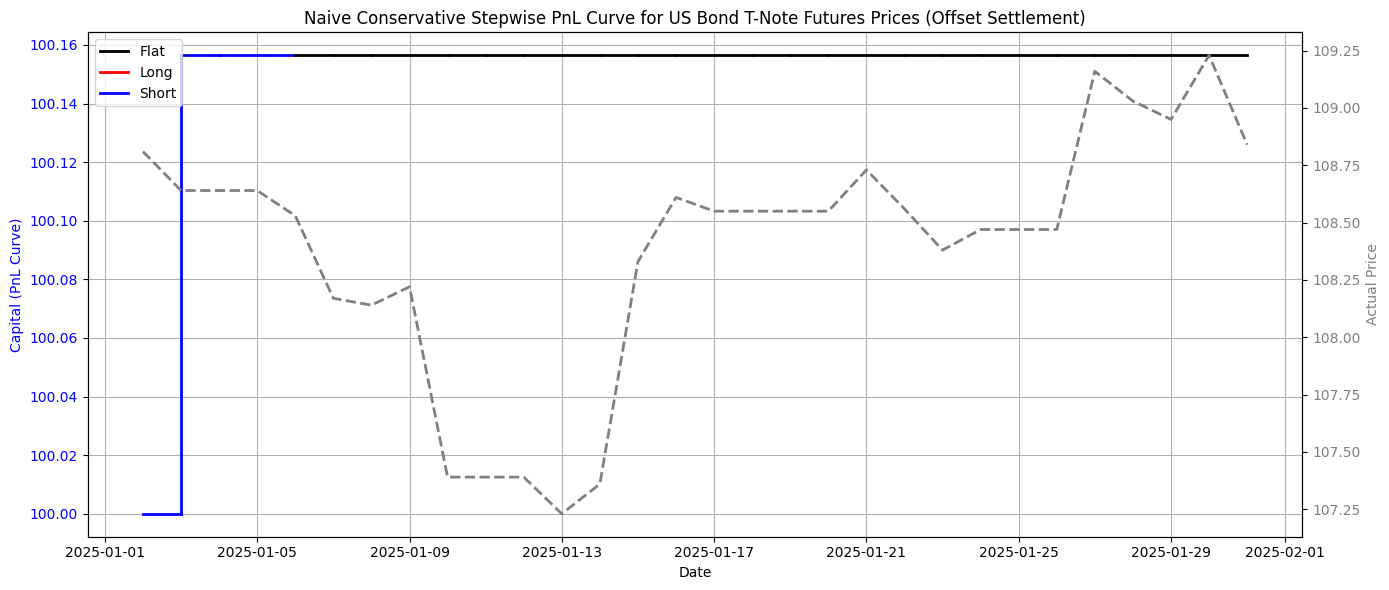

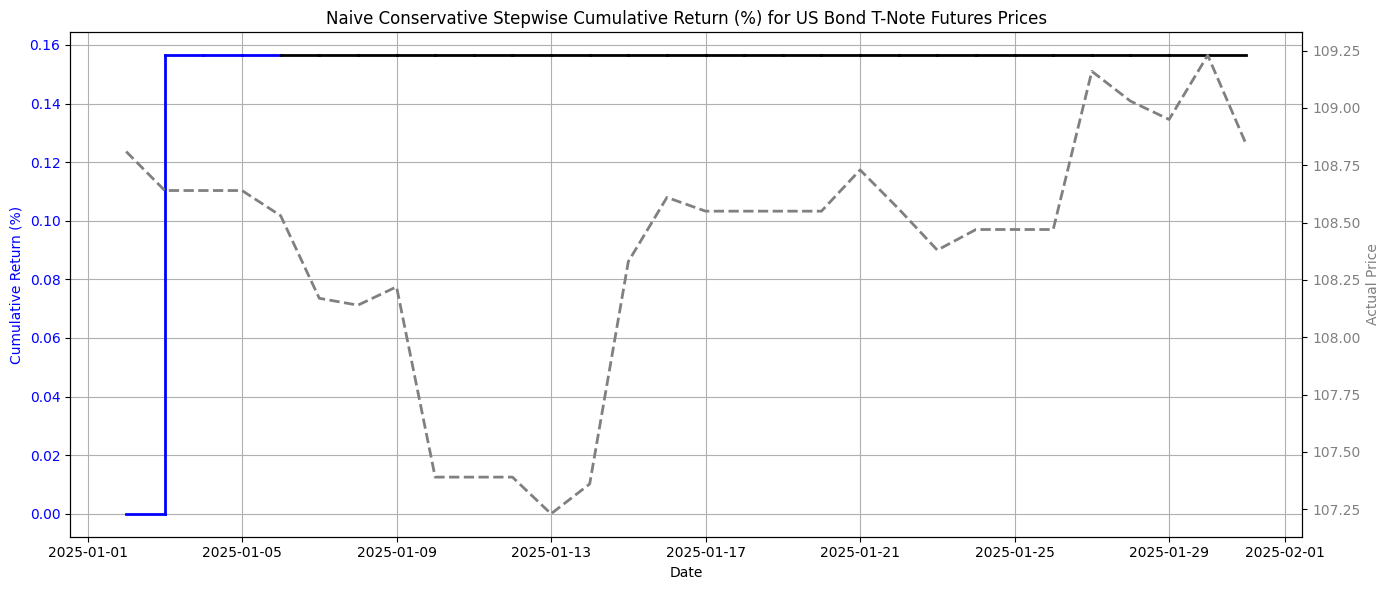

===== Naive OptimisticTrade Log =====
Short | 2025-01-02 -> 2025-01-03 (2 days) | Entry=108.81, Exit=108.64 (AbsDiff=0.17) | Return: 0.16% | EndCapital=100.16
Long  | 2025-01-06 -> 2025-01-31 (19 days) | Entry=108.53, Exit=108.84 (AbsDiff=0.31) | Return: 0.29% | EndCapital=100.44

=== Final Results (Naive Optimistic) ===
Final capital  = 100.44
Final PnL      = 0.44
Final Return   = 0.44%



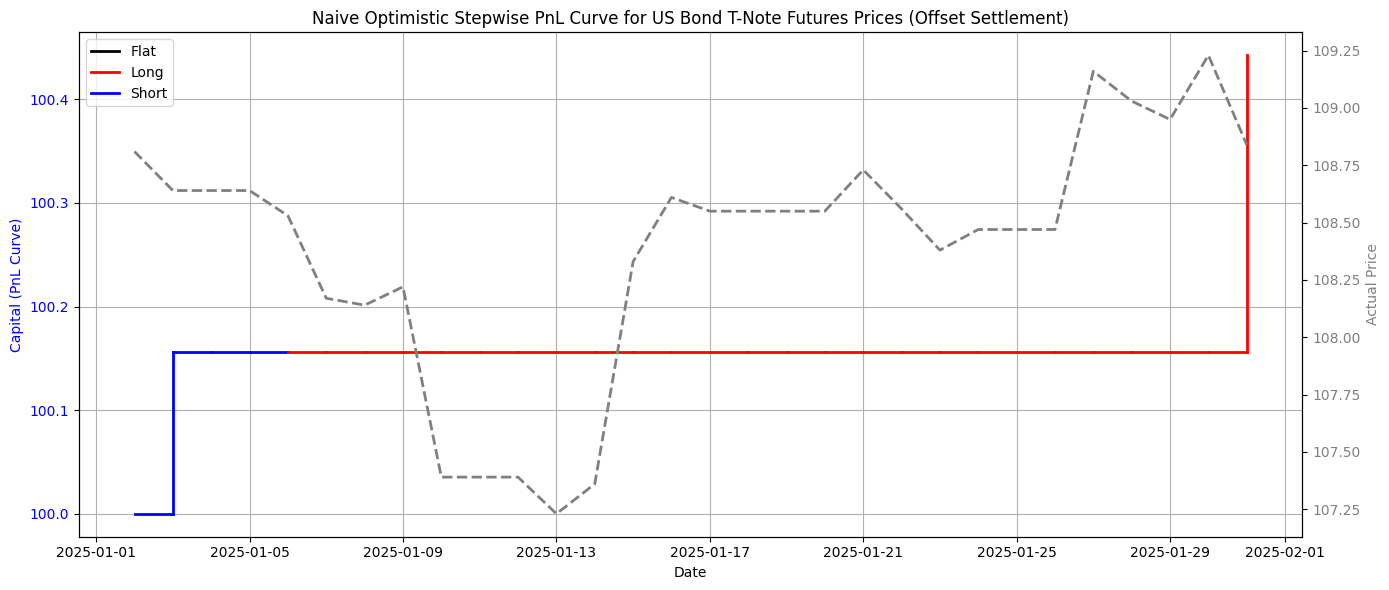

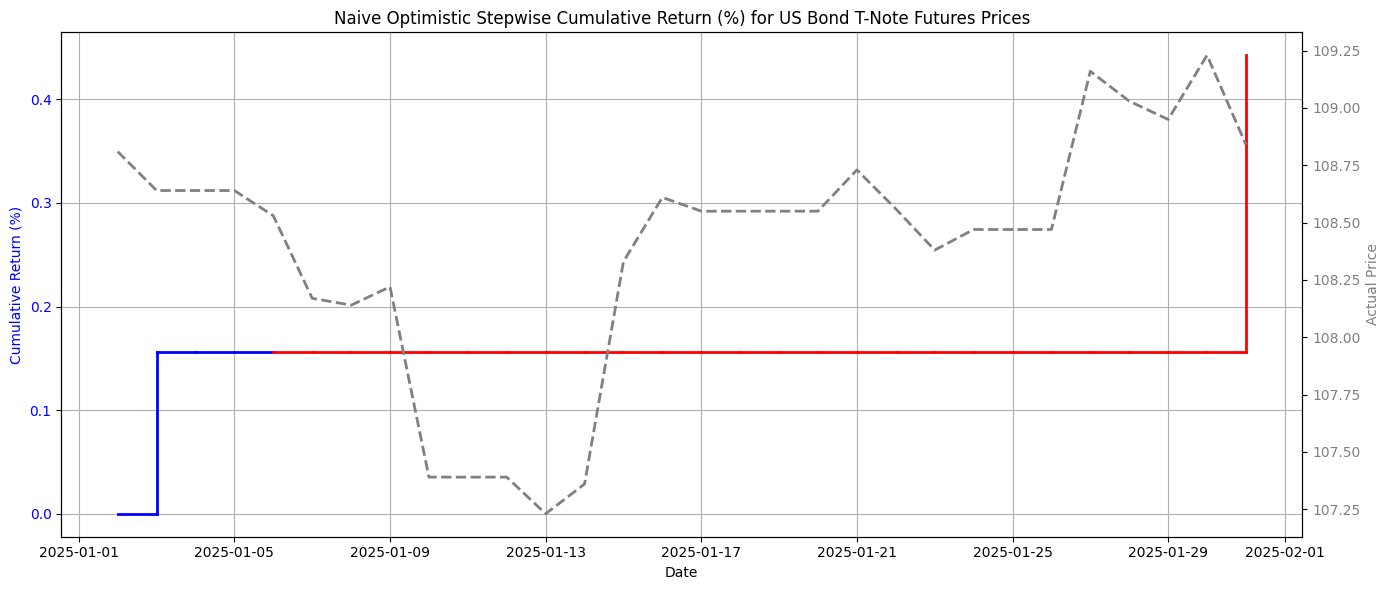

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

###############################################################################
# A. Setup & Data
###############################################################################
# Assumptions:
#   df_test_poly: DataFrame with columns ["Date", "Actual", "mdates_num"]
#   best_model_names: list of model strings (e.g. ["SVM", "GRU", ...])
#   best_poly_info: dict with "coeffs" for each model and "Actual".
#
# Example:
# best_model_names = ["SVM", "GRU", "RNN", "LSTM", "N-HITS", "CNN", "Transformer", "N-BEATS", "Boost"]
# if "Actual" not in best_poly_info:
#     raise ValueError("best_poly_info must include an 'Actual' entry for the real price polynomial.")

df_test_poly = df_test_poly.sort_values("Date").reset_index(drop=True)
n_days = len(df_test_poly)

# 1) Compute each model's polynomial derivative ("gradient") at each day.
model_gradients = {}
for model in best_model_names:
    # Get polynomial coeffs for this model
    coeffs = best_poly_info[model]["coeffs"]
    d_coeffs = np.polyder(coeffs)  # derivative polynomial coefficients
    # Evaluate derivative at each date
    model_gradients[model] = np.polyval(d_coeffs, df_test_poly["mdates_num"])

###############################################################################
# B. Define signals for Naive Conservative & Naive Optimistic
###############################################################################
signals_conservative = np.zeros(n_days, dtype=int)
signals_optimistic   = np.zeros(n_days, dtype=int)

for i in range(n_days):
    # All model gradients for day i
    grads = [model_gradients[m][i] for m in best_model_names]
    
    # ---- Naive Conservative ----
    all_positive = all(g > 0 for g in grads)
    all_negative = all(g < 0 for g in grads)
    
    if all_positive:
        signals_conservative[i] = 1   # Long
    elif all_negative:
        signals_conservative[i] = -1  # Short
    else:
        signals_conservative[i] = 0   # Flat
    
    # ---- Naive Optimistic ----
    any_positive = any(g > 0 for g in grads)
    any_negative = any(g < 0 for g in grads)
    
    if any_positive:
        signals_optimistic[i] = 1   # Long
    elif any_negative:
        signals_optimistic[i] = -1  # Short
    else:
        signals_optimistic[i] = 0   # Flat

###############################################################################
# C. Piecewise Trading Simulation (Offset) Utility
###############################################################################
def get_plot_segments(df, signal_col="Signal"):
    """
    Identify contiguous segments with the same signal.
    Returns a list of tuples: (start_index, end_index, signal_value).
    """
    segs = []
    start_idx = 0
    curr_signal = df.loc[0, signal_col]
    for idx in range(1, len(df)):
        if df.loc[idx, signal_col] != curr_signal:
            segs.append((start_idx, idx - 1, curr_signal))
            start_idx = idx
            curr_signal = df.loc[idx, signal_col]
    segs.append((start_idx, len(df) - 1, curr_signal))
    return segs

def piecewise_trading_simulation_offset(df_signal):
    """
    Simulate trading using daily signals with an offset-based approach.
      - Start capital = $100
      - For a multi-day segment (>=2 days), realize PnL at the final day
      - 1-day segments are effectively ignored/flat
    """
    segments = get_plot_segments(df_signal, "Signal")
    
    capital = 100.0
    cap_arr = np.zeros(len(df_signal))
    trade_log = []
    
    for (start, end, sig) in segments:
        start_date = df_signal.loc[start, "Date"]
        end_date   = df_signal.loc[end, "Date"]
        seg_days   = end - start + 1
        
        # Propagate current capital for the entire [start..end] segment
        for i in range(start, end + 1):
            cap_arr[i] = capital
        
        # If the segment is <2 days, treat as flat/ignored
        if seg_days < 2:
            trade_log.append({
                "Signal": "Flat(ignored)",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": df_signal.loc[start, "Actual"],
                "ExitPrice": df_signal.loc[end, "Actual"],
                "AbsDiff": 0.0,
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
            continue
        
        if sig == 0:
            # Flat
            trade_log.append({
                "Signal": "Flat",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": df_signal.loc[start, "Actual"],
                "ExitPrice": df_signal.loc[end, "Actual"],
                "AbsDiff": abs(df_signal.loc[end, "Actual"] - df_signal.loc[start, "Actual"]),
                "SegmentReturn(%)": 0.0,
                "EndCapital": capital
            })
        elif sig == 1:
            # Long
            entry_price = df_signal.loc[start, "Actual"]
            exit_price  = df_signal.loc[end, "Actual"]
            final_cap   = capital * (exit_price / entry_price)  # Realize PnL at 'end'
            seg_return  = (final_cap / capital) - 1.0
            
            cap_arr[end] = final_cap
            capital = final_cap
            
            trade_log.append({
                "Signal": "Long",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_return * 100.0,
                "EndCapital": final_cap
            })
        else:
            # Short
            entry_price = df_signal.loc[start, "Actual"]
            exit_price  = df_signal.loc[end, "Actual"]
            final_cap   = capital * (entry_price / exit_price)
            seg_return  = (final_cap / capital) - 1.0
            
            cap_arr[end] = final_cap
            capital = final_cap
            
            trade_log.append({
                "Signal": "Short",
                "StartDate": start_date,
                "EndDate": end_date,
                "Days": seg_days,
                "EntryPrice": entry_price,
                "ExitPrice": exit_price,
                "AbsDiff": abs(exit_price - entry_price),
                "SegmentReturn(%)": seg_return * 100.0,
                "EndCapital": final_cap
            })
    
    # Forward-fill capital after the final segment
    last_cap = capital
    for i in range(len(df_signal)):
        if cap_arr[i] == 0.0:
            cap_arr[i] = last_cap
        else:
            last_cap = cap_arr[i]
    
    df_signal["Capital"] = cap_arr
    df_signal["Cumulative_PnL"] = df_signal["Capital"] - 100.0
    df_signal["Cumulative_Return"] = (df_signal["Cumulative_PnL"] / 100.0) * 100.0
    
    return df_signal, trade_log

###############################################################################
# D. Utility: Reindex to Complete Daily Frequency
###############################################################################
def reindex_to_daily(df_signal):
    """
    Reindex to all calendar days from min to max date, forward-fill Actual/Capital.
    """
    df_signal = df_signal.copy()
    df_signal.set_index("Date", inplace=True)
    all_days = pd.date_range(start=df_signal.index.min(), end=df_signal.index.max(), freq="D")
    df_signal = df_signal.reindex(all_days)
    
    # Forward-fill numeric columns
    df_signal["Actual"].ffill(inplace=True)
    df_signal["Capital"].ffill(inplace=True)
    df_signal["Cumulative_PnL"].ffill(inplace=True)
    df_signal["Cumulative_Return"].ffill(inplace=True)
    df_signal["Signal"].ffill(inplace=True)
    
    df_signal.reset_index(inplace=True)
    df_signal.rename(columns={"index": "Date"}, inplace=True)
    return df_signal

###############################################################################
# E. Plotting Functions
###############################################################################
def plot_piecewise_results_daybyday(df_signal, trade_log, title_prefix=""):
    """
    Stepwise PnL curve. Color-coded by signal: 0 => black, 1 => red, -1 => blue.
    Also prints trade log and final results.
    """
    # Print trade log
    print(f"===== {title_prefix}Trade Log =====")
    for trd in trade_log:
        print(
            f"{trd['Signal']:5s} | {trd['StartDate'].date()} -> {trd['EndDate'].date()} "
            f"({trd['Days']} days) | "
            f"Entry={trd['EntryPrice']:.2f}, Exit={trd['ExitPrice']:.2f} "
            f"(AbsDiff={trd['AbsDiff']:.2f}) | "
            f"Return: {trd['SegmentReturn(%)']:.2f}% | "
            f"EndCapital={trd['EndCapital']:.2f}"
        )
    
    final_cap = df_signal["Capital"].iloc[-1]
    final_pnl = df_signal["Cumulative_PnL"].iloc[-1]
    final_ret = df_signal["Cumulative_Return"].iloc[-1]
    print(f"\n=== Final Results ({title_prefix}) ===")
    print(f"Final capital  = {final_cap:.2f}")
    print(f"Final PnL      = {final_pnl:.2f}")
    print(f"Final Return   = {final_ret:.2f}%\n")
    
    # Stepwise plot
    fig, ax1 = plt.subplots(figsize=(14, 6))
    color_map = {0: "black", 1: "red", -1: "blue"}
    
    n_rows = len(df_signal)
    for i in range(1, n_rows):
        sig_prev = int(df_signal.loc[i-1, "Signal"])
        
        x_vals_horiz = [df_signal.loc[i-1, "Date"], df_signal.loc[i, "Date"]]
        y_vals_horiz = [df_signal.loc[i-1, "Capital"], df_signal.loc[i-1, "Capital"]]
        ax1.plot(x_vals_horiz, y_vals_horiz, color=color_map[sig_prev], linewidth=2)
        
        x_vals_vert = [df_signal.loc[i, "Date"], df_signal.loc[i, "Date"]]
        y_vals_vert = [df_signal.loc[i-1, "Capital"], df_signal.loc[i, "Capital"]]
        ax1.plot(x_vals_vert, y_vals_vert, color=color_map[sig_prev], linewidth=2)
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Capital (PnL Curve)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)
    
    # Plot actual price on twin axis
    ax2 = ax1.twinx()
    ax2.plot(df_signal["Date"], df_signal["Actual"], color="gray", linestyle="--", linewidth=2)
    ax2.set_ylabel("Actual Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")
    
    legend_elems = [
        Line2D([0], [0], color='black', lw=2, label='Flat'),
        Line2D([0], [0], color='red',   lw=2, label='Long'),
        Line2D([0], [0], color='blue',  lw=2, label='Short')
    ]
    ax1.legend(handles=legend_elems, loc="upper left")
    ax1.set_title(f"{title_prefix} Stepwise PnL Curve for US Bond T-Note Futures Prices (Offset Settlement)")
    plt.tight_layout()
    plt.show()

def plot_piecewise_results_daybyday_pct(df_signal, title_prefix=""):
    """
    Plots the stepwise Cumulative Return (%) vs Date. Signals color-coded.
    """
    fig, ax1 = plt.subplots(figsize=(14, 6))
    color_map = {0: "black", 1: "red", -1: "blue"}
    
    n_rows = len(df_signal)
    for i in range(1, n_rows):
        sig_prev = int(df_signal.loc[i-1, "Signal"])
        
        x_vals_horiz = [df_signal.loc[i-1, "Date"], df_signal.loc[i, "Date"]]
        y_vals_horiz = [df_signal.loc[i-1, "Cumulative_Return"], df_signal.loc[i-1, "Cumulative_Return"]]
        ax1.plot(x_vals_horiz, y_vals_horiz, color=color_map[sig_prev], linewidth=2)
        
        x_vals_vert = [df_signal.loc[i, "Date"], df_signal.loc[i, "Date"]]
        y_vals_vert = [df_signal.loc[i-1, "Cumulative_Return"], df_signal.loc[i, "Cumulative_Return"]]
        ax1.plot(x_vals_vert, y_vals_vert, color=color_map[sig_prev], linewidth=2)
    
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Cumulative Return (%)", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(df_signal["Date"], df_signal["Actual"], color="gray", linestyle="--", linewidth=2)
    ax2.set_ylabel("Actual Price", color="gray")
    ax2.tick_params(axis='y', labelcolor="gray")
    
    ax1.set_title(f"{title_prefix} Stepwise Cumulative Return (%) for US Bond T-Note Futures Prices")
    plt.tight_layout()
    plt.show()

###############################################################################
# F. Run Simulations & Plots for Each Strategy
###############################################################################
# -- 1) NAIVE CONSERVATIVE STRATEGY --
df_con = df_test_poly.copy()
df_con["Signal"] = signals_conservative

df_con_sim, trade_log_con = piecewise_trading_simulation_offset(df_con)
df_con_sim = reindex_to_daily(df_con_sim)  # reindex for day-by-day plotting

# Plots & Logs
plot_piecewise_results_daybyday(df_con_sim, trade_log_con, title_prefix="Naive Conservative")
plot_piecewise_results_daybyday_pct(df_con_sim, title_prefix="Naive Conservative")

# -- 2) NAIVE OPTIMISTIC STRATEGY --
df_opt = df_test_poly.copy()
df_opt["Signal"] = signals_optimistic

df_opt_sim, trade_log_opt = piecewise_trading_simulation_offset(df_opt)
df_opt_sim = reindex_to_daily(df_opt_sim)  # reindex for day-by-day plotting

# Plots & Logs
plot_piecewise_results_daybyday(df_opt_sim, trade_log_opt, title_prefix="Naive Optimistic")
plot_piecewise_results_daybyday_pct(df_opt_sim, title_prefix="Naive Optimistic")
